# Using Playtime and Age on a Minecraft Server to Predict Game-Related Newsletter Subscription 

### Julia Dargacz, Karan Johal, Jenny Lee, Morgan Omstead

## Introduction

Player analytics plays an important role in the gaming industry and can help gaming businesses and developers understand players' behaviours, preferences, and motivations (Lark Editorial Team, 2024). By tracking key data like engagement, retention, and monetization, developers can create better strategies for success (Lark Editorial Team, 2024). Understanding player behaviour and finding patterns in their gameplay can help developers see the game from the player's perspective which can then help make the game more enjoyable for future and current players (iXie, 2024). The video game industry is competitive (Niles, 2024) and player analytics can be a helpful tool for developers to make user experiences more engaging.

At UBC, Frank Wood is leading a Computer Science research group that is studying how people play video games. Players' actions were tracked on a Minecraft server and were put into the players.csv and sessions.csv files. This report aims to answer a key question about one of these datasets: Can hours played and age predict the newsletter subscriber status in the player dataset? This question will be answered through an in-depth analysis of the players.csv file given for the project. A table is provided below that shows all the variable's names, types, and meanings.

The players.csv file has data on 196 players, with each measured in seven different variables.

| Variable | Type | Meaning|
|:--------|:--------|:--------|
| experience |Categorical <character.>|	The level of experience of the user, given by their selection of five options.|
|  subscribe |Binary <logical.>	|Whether the user is subscribed to emails from PLAICraft, TRUE meaning they are subscribed.|
|  hashedEmail|  Categorical <character.>	|The unique, encrypted email address for each user |
|played_hours| Quantitative <double.>	| How many hours the user has played PLAICraft.|
|name| Categorical <character.>	| The user's first name. |
|gender| Categorical <character.>	| The gender of the user. |
|Age| Quantitative <double.>	| The age of the user. |


## Methods & Results

In [2]:
install.packages("kknn")

also installing the dependency ‘igraph’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
tidymodels_prefer()


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Data Wrangling
First, the `players.csv` data must be loaded into the notebook. After loading, the data must be wrangled so it is suitable for analysis. The first step in wrangling involved selecting the columns `Age`, `played_hours`, and `subscribe`. Any row containing missing values was dropped from the final data and the `subscribe` column was converted into a factor for further classification to be possible. The new data was assigned to `players`. The data was then counted once wrangling was complete to find that 196 individual observations remained and 72.45% of players were subscribed to the newsletter (142/196 players). 

In [4]:
players <- read_csv("https://raw.githubusercontent.com/momste01/individual_project/refs/heads/main/players.csv") |>
  select(Age, played_hours, subscribe) |>
  drop_na() |>
  mutate(subscribe = as_factor(subscribe))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
set.seed(1234)

split <- initial_split(players, prop = 0.8, strata = subscribe)
train <- training(split)
test <- testing(split)

In [6]:
train |> count(subscribe)

subscribe,n
<fct>,<int>
FALSE,41
TRUE,113


### Exploratory Data Analysis (EDA)
Using the wrangled players data, an age distribution graph was created using `ggplot`, age was plotted on the x axis and the number of people of that age (count) was plotted on the y axis. Colours were used to show whether the players were subscribed (blue) or not subscribed (red) to the newsletter, this graph is labelled **Figure 1**. Similar graphs were created showing the correlation between hours of Minecraft played (**Figure 2**) and finally, a scatter plot plotting age vs hours played (**Figure 3**) all including whether players were subscribed to the newsletter or not. 

Warning message:
“Removed 28 rows containing missing values or values outside the scale range
(`geom_bar()`).”


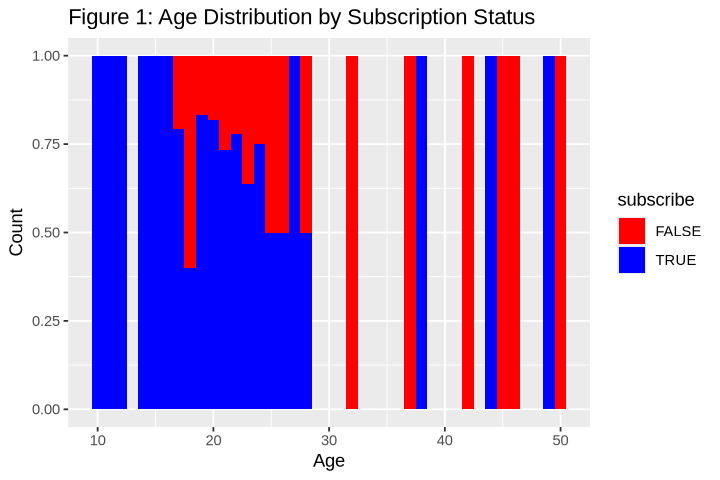

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)

# Age distribution
train |> 
  ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 1, position = "fill") +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 1: Age Distribution by Subscription Status", x = "Age", y = "Count")


This histogram shows the age distribution of players in the training set, separated by subscription status. Blue bars represent subscribed players (TRUE), and red bars represent unsubscribed players (FALSE). The distribution is slightly skewed toward younger players.

Warning message:
“Removed 28 rows containing missing values or values outside the scale range
(`geom_bar()`).”


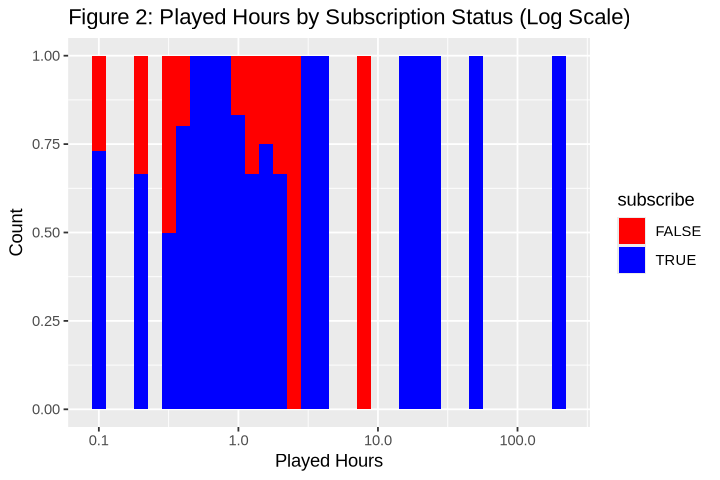

In [8]:
# Played hours (log)
train |> 
  filter(played_hours > 0) |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 0.1, position = "fill") +
  scale_x_log10() +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 2: Played Hours by Subscription Status (Log Scale)", x = "Played Hours", y = "Count")


This histogram shows the total hours played by each player, separated by subscription status. Subscribed players (blue) tend to have slightly more hours played than unsubscribed players (red), though there is overlap between both groups.

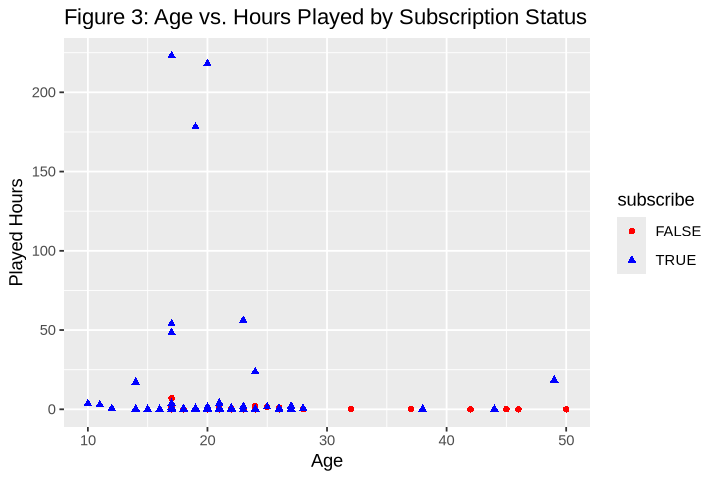

In [9]:
# Scatter plot
train |> 
  ggplot(aes(x = Age, y = played_hours, color = subscribe, shape = subscribe)) +
  geom_point() +
  scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 3: Age vs. Hours Played by Subscription Status", x = "Age", y = "Played Hours")


A scatterplot of Age vs. Played Hours in the training set, with color indicating subscription status. This helps visualize any clustering or trends between the predictors and the outcome variable. No clear boundary between subscribed and unsubscribed players is visually apparent.



### Model Training and Selection
 In order to begin model training, the dataset needed to be split 80% into training data, and 20% for testing. All predictors were normalised so the data is consistent and all variables carry the same weight when doing the analysis. K nearest neighbor classification was chosen and 5-fold cross validation was used to tune K from 1 to 20. K= 18 was then selected because it had the highest validation accuracy. **Figure 4** shows the cross validation accuracy compared to each value of K.

In [10]:

recipe_knn <- recipe(subscribe ~ Age + played_hours, data = train) |>
  step_normalize(all_predictors())

knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = tune(),
  weight_func = "rectangular"
) |> set_engine("kknn")

knn_wf <- workflow() |>
  add_recipe(recipe_knn) |>
  add_model(knn_spec)

folds <- vfold_cv(train, v = 5, strata = subscribe)

results <- tune_grid(knn_wf, resamples = folds, grid = tibble(neighbors = 1:20))


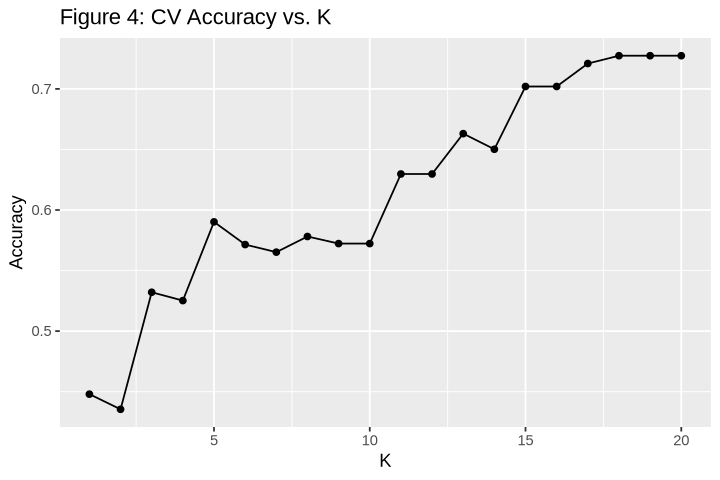

In [11]:
# CV accuracy plot
results |> 
  collect_metrics() |> 
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 4: CV Accuracy vs. K", x = "K", y = "Accuracy")


This line plot shows the model's cross-validated accuracy for different values of k (the number of neighbors in KNN). The optimal k is selected based on the highest average accuracy across 5 folds. This plot helps determine which value of k provides the best balance between bias and variance.

In [12]:
best_k <- select_best(results, metric = "accuracy")
best_k


neighbors,.config
<int>,<chr>
18,Preprocessor1_Model18


### Model Evaluation
Using K=18, the workflow was finalized and trained using the training set. It was then evaluated on accuracy using the confusion matrix test. Accuracy was determined to be 72.5% from these tests. 

In [20]:
final_wf <- finalize_workflow(knn_wf, best_k)
final_fit <- last_fit(final_wf, split)

collect_metrics(final_fit)


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7250000,Preprocessor1_Model1
roc_auc,binary,0.5658307,Preprocessor1_Model1
brier_class,binary,0.2002315,Preprocessor1_Model1


In [17]:
final_fit |> 
  collect_predictions() |> 
  conf_mat(truth = subscribe, estimate = .pred_class)


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     11   29

New names:
• `subscribe` -> `subscribe...3`
• `subscribe` -> `subscribe...9`


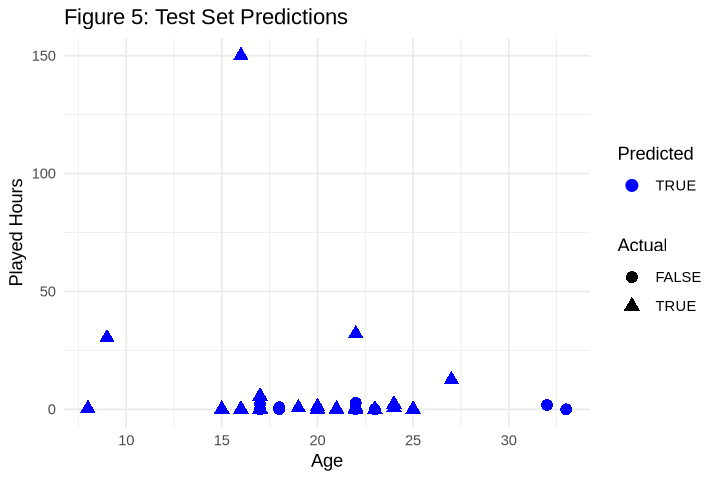

In [15]:

pred_data <- final_fit |> collect_predictions()

test_preds <- bind_cols(test, pred_data) |> 
  rename(actual = subscribe...3, predicted = .pred_class)


ggplot(test_preds, aes(x = Age, y = played_hours, color = predicted, shape = actual)) +
  geom_point(size = 3) +
  scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(
    title = "Figure 5: Test Set Predictions",
    x = "Age",
    y = "Played Hours",
    color = "Predicted",
    shape = "Actual"
  ) +
  theme_minimal()


Each point represents a test set player, with x = Age and y = Played Hours. The color indicates the class predicted by the model (blue = subscribed, red = unsubscribed), while the shape represents the actual class (triangle = subscribed, circle = unsubscribed). This allows visual comparison of predicted vs. actual labels.

## Results
**Figure 5** shows a graph that was coded to represent the model’s prediction of subscriber status compared to the known subscriber status of players. The model classified all TRUE values, indicating that every player was subscribed to the newsletter. This is known to not be true, as previously mentioned, only 72.45% of players were actually subscribed to the newsletter. Therefore, only using `Age` and `played_hours` in k nearest neighbor analysis is not an accurate method to determine subscriber status of players. In order for this type of analysis to be more accurate, more data would need to be collected, including more `FALSE` subscriber status. Expanding the data can be beneficial as  the model automatically trains to denote every new observation as `TRUE` for subscriber status due to the high proportion of newsletter subscribers present in the data; any new observation follows the trend of the majority of players being subscribed to the newsletter. 

### Discussion
To explore if hours played and the age of Minecraft gamers can predict their tendency of them to subcribe to the Minecraft newsletter, we created a classifying model, which was evaluated to be 72.5% accurate. With our preliminary data exploration, visualising the relationship between subscription status and both age and played hours, we expected positive relationship between lower ages (10-20 years) and greater played hours to newsletter subscription tendency. Unfortunately, as discussed in our results, our model inaccurately classified all players as newsletter subscribers. One of the reasons for our model’s poor performance could be due to the imbalance of subscribed players in the data. Since the dataset has much more subscribed players (143) than non-subscribers (52), our model likely has learned to predict subscription status for every player, overfitting to the majority class. Our model could have also been influenced by unrelated noise (ex. outliers, incorrect labels) which could have further caused troubles in our model. For more accurate and generalisable results, more data, especially from non-subscribers, must be obtained. Furthermore, using 10-fold cross-validation instead of 5 could reduce overfitting and improve accuracy and generalisability, as the model is evaluated with more frequent, smaller test sets, making sure that the model is not biased by a single training-test split. 

### Impact of Findings
Building a KNN classification model to predict newsletter subscription status based on player characteristics like age and hours played is crucial for the gaming industry in many different areas. As players’ subscription status implies how interested and engaged the players are with the game, identifying which type of players are more likely to subscribe can help the marketing team to personalise their promotions and content to target the specific types of players. Moreover, analysing playing duration, age and subscription can provide valuable insights for game development, helping gaming companies to effectively create new features and events catered towards target player groups.


### Future Questions
- How can we strategically recruit players who have not subscribed with minimal selection bias?
- Does subscription status actually represent the interest and engagement level of players?
- Can gaming experience level and age predict the number of hours a player is likely to play?
- What other predictive models can be used to predict subscription status based on player characteristics like age and gender?

## References

iXie. (2024, March 25). _The Role of Player behavior Analytics in Gaming_. IXie Gaming. https://www.ixiegaming.com/blog/role-of-player-behavior-analytics-in-gaming/

Kuhn, M., Silge, J., & tidymodels contributors. (n.d.). Tidymodels. https://www.tidymodels.org

Lark Editorial Team. (2024, June 25). _Player Analytics_. Larksuite.com. https://www.larksuite.com/en_us/topics/gaming-glossary/player-analytics

Niles V. (2024, May 15). _How to Become a Video Game Developer_. TechGuide. https://techguide.org/careers/video-game-developer/